## Figure 1

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
n_snps = 1000
n_samp_target = 50000
freq_snps = np.random.uniform(low=0.1, high=0.9, size=n_snps)

nh2 = 3
nrg = 3

h2s = np.linspace(0, 0.5, nh2)
rgs = np.linspace(-1, 1, nrg)
b0s = np.linspace(-3, 3, 7)
labels = []

#pfs = np.linspace(0, 1, 5)

bs = []
ses = []

for b0 in b0s:
    p = 1/(1+np.exp(-b0))
    n_samp = int(n_samp_target/p)
    
    # simulate genotype
    gt = np.random.binomial(2, freq_snps, size=(n_samp, n_snps))
    
    # normalize genotype
    gt_norm = (gt - gt.mean(axis=0)) / gt.std(axis=0)
    
    # simulate selection
    for h2 in h2s:
        for rg in rgs:
            betas = np.random.multivariate_normal(np.zeros(2), [[h2, rg * h2], [rg * h2, h2]], size=n_snps) / np.sqrt(n_snps)
            noise = np.random.multivariate_normal(np.zeros(2), np.eye(2) * (1-h2), size=gt_norm.shape[0])
            c_liab = (gt_norm @ betas) + noise + b0
            c2d = np.random.binomial(1, p=1/(1+np.exp(-c_liab)))
            
            sex = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            c = c2d[:,0] * (1-sex) + c2d[:,1] * sex
            
            # select samples and run regression
            gt_norm_c = gt_norm[c.astype(bool),:]
            sex_c = sex[c.astype(bool)]
            beta = np.zeros(n_snps)
            se = np.zeros(n_snps)
            for i_snp in range(n_snps):
                mod = sm.GLM(endog=sex_c, exog=sm.add_constant(gt_norm_c[:,i_snp]), family=sm.families.Binomial()).fit()
                beta[i_snp] = mod.params[1]
                se[i_snp] = mod.bse[1]
            bs.append(beta)
            ses.append(se)
            labels.append([b0, h2, rg])
            

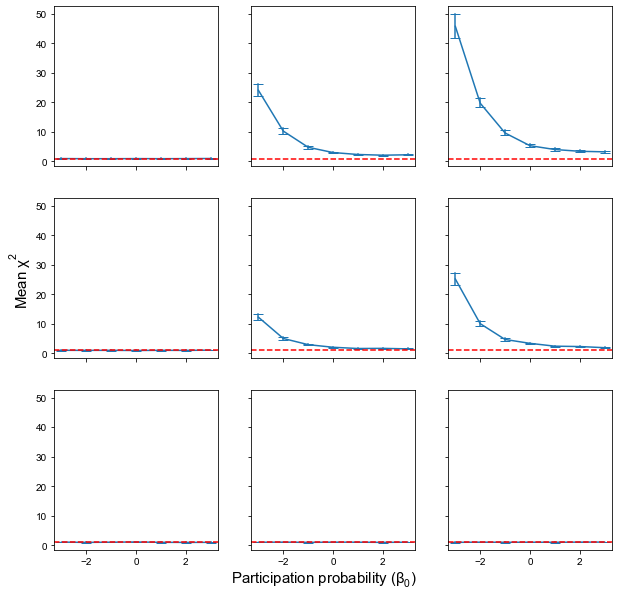

In [34]:
fig, ax = plt.subplots(nh2,nrg,figsize=(10,10), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        betas = []
        errs = []
        labs = []
        for i_b0, b0 in enumerate(b0s):
            betas.append(bs[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs.append(ses[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            labs.append(labels[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        data_plot = pd.melt(pd.DataFrame((np.array(betas)/np.array(errs)).T ** 2))
        data_plot['variable'] = data_plot['variable'] -3
        sns.lineplot(x='variable',
                     y='value', 
                     data=data_plot, 
                     err_style='bars', 
                     ax=ax[i_rg, i_h2],
                     err_kws={'capsize':5})
        ax[i_rg,i_h2].axhline(1, color='red', ls='--')
        
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        
fig.text(0.06, 0.5, r'Mean $\chi^2$', rotation='vertical', fontsize=15, va='center')
fig.text(0.5, 0.08, r'Participation probability ($\beta_0$)', fontsize=15, ha='center')

plt.show()

## Figure 2

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
n_snps = 1000
n_samp_target = 50000
freq_snps = np.random.uniform(low=0.1, high=0.9, size=n_snps)

nh2 = 4
nrg = 3

h2s = np.linspace(0, 0.3, nh2)
rgs = np.linspace(-1, 1, nrg)
b0s = np.linspace(-4, 4, 5)
labels = []

bs_1 = []
ses_1 = []
bs0_1 = []
ses0_1 = []
bs1_1 = []
ses1_1 = []

bs_2 = []
ses_2 = []
bs0_2 = []
ses0_2 = []
bs1_2 = []
ses1_2 = []

for b0 in b0s:
    p = 1/(1+np.exp(-b0))
    n_samp = int(n_samp_target/p)
    
    # simulate genotype
    gt = np.random.binomial(2, freq_snps, size=(n_samp, n_snps))
    
    # normalize genotype
    gt_norm = (gt - gt.mean(axis=0)) / gt.std(axis=0)
    
    # simulate selection
    for h2 in h2s:
        for rg in rgs:
            betas = np.random.multivariate_normal(np.zeros(2), [[h2, rg * h2], [rg * h2, h2]], size=n_snps) / np.sqrt(n_snps)
            noise = np.random.multivariate_normal(np.zeros(2), np.eye(2) * (1-h2), size=gt_norm.shape[0])
            
            y1 = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            y2 = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            sex = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            
            c_liab = (gt_norm @ betas) + noise + b0
            c1_liab = c_liab + 0.5 * ((2*sex-1) * y1)[:,None]
            c2_liab = c_liab + 0.5 * ((2*sex-1) * y2)[:,None]
            
            c1d = np.random.binomial(1, p=1/(1+np.exp(-c1_liab)))
            c2d = np.random.binomial(1, p=1/(1+np.exp(-c2_liab)))
            
            c1 = c1d[:,0] * (1-sex) + c1d[:,1] * sex
            c2 = c2d[:,0] * (1-sex) + c2d[:,1] * sex 
             
            # select samples and run regression
            gt_norm_c1 = gt_norm[c1.astype(bool),:]
            gt_norm_c2 = gt_norm[c2.astype(bool),:]
            sex_c1 = sex[c1.astype(bool)]
            sex_c2 = sex[c2.astype(bool)]
            y1_c = y1[c1.astype(bool)]
            y2_c = y2[c2.astype(bool)]
            
            beta_1 = np.zeros(n_snps)
            se_1 = np.zeros(n_snps)
            beta0_1 = np.zeros(n_snps)
            se0_1 = np.zeros(n_snps)
            beta1_1 = np.zeros(n_snps)
            se1_1 = np.zeros(n_snps)
            
            beta_2 = np.zeros(n_snps)
            se_2 = np.zeros(n_snps)
            beta0_2 = np.zeros(n_snps)
            se0_2 = np.zeros(n_snps)
            beta1_2 = np.zeros(n_snps)
            se1_2 = np.zeros(n_snps)
            
            for i_snp in range(n_snps):
                mod_1 = sm.GLM(endog=y1_c, exog=sm.add_constant(gt_norm_c1[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_1[i_snp] = mod_1.params[1]
                se_1[i_snp] = mod_1.bse[1]
                
                mod0_1 = sm.GLM(endog=y1_c[sex_c1==0], exog=sm.add_constant(gt_norm_c1[sex_c1==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_1[i_snp] = mod0_1.params[1]
                se0_1[i_snp] = mod0_1.bse[1]
                
                mod1_1 = sm.GLM(endog=y1_c[sex_c1==1], exog=sm.add_constant(gt_norm_c1[sex_c1==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_1[i_snp] = mod1_1.params[1]
                se1_1[i_snp] = mod1_1.bse[1]
                # ---------------------------------------------------------------------------------------
                mod_2 = sm.GLM(endog=y2_c, exog=sm.add_constant(gt_norm_c2[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_2[i_snp] = mod_2.params[1]
                se_2[i_snp] = mod_2.bse[1]
                
                mod0_2 = sm.GLM(endog=y2_c[sex_c2==0], exog=sm.add_constant(gt_norm_c2[sex_c2==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_2[i_snp] = mod0_2.params[1]
                se0_2[i_snp] = mod0_2.bse[1]
                
                mod1_2 = sm.GLM(endog=y2_c[sex_c2==1], exog=sm.add_constant(gt_norm_c2[sex_c2==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_2[i_snp] = mod1_2.params[1]
                se1_2[i_snp] = mod1_2.bse[1]
                
            bs_1.append(beta_1)
            ses_1.append(se_1)
            bs0_1.append(beta0_1)
            ses0_1.append(se0_1)
            bs1_1.append(beta1_1)
            ses1_1.append(se1_1)
            
            bs_2.append(beta_2)
            ses_2.append(se_2)
            bs0_2.append(beta0_2)
            ses0_2.append(se0_2)
            bs1_2.append(beta1_2)
            ses1_2.append(se1_2)
            
            labels.append([b0, h2, rg])

import pickle
save_data = [bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2]
file_to_store = open("result/participation_0.5.pickle", "wb")
pickle.dump(save_data, file_to_store)
file_to_store.close()

In [35]:
with open('result/participation_0.5.pickle', 'rb') as f:
    data_load = pickle.load(f)
    bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2 = data_load

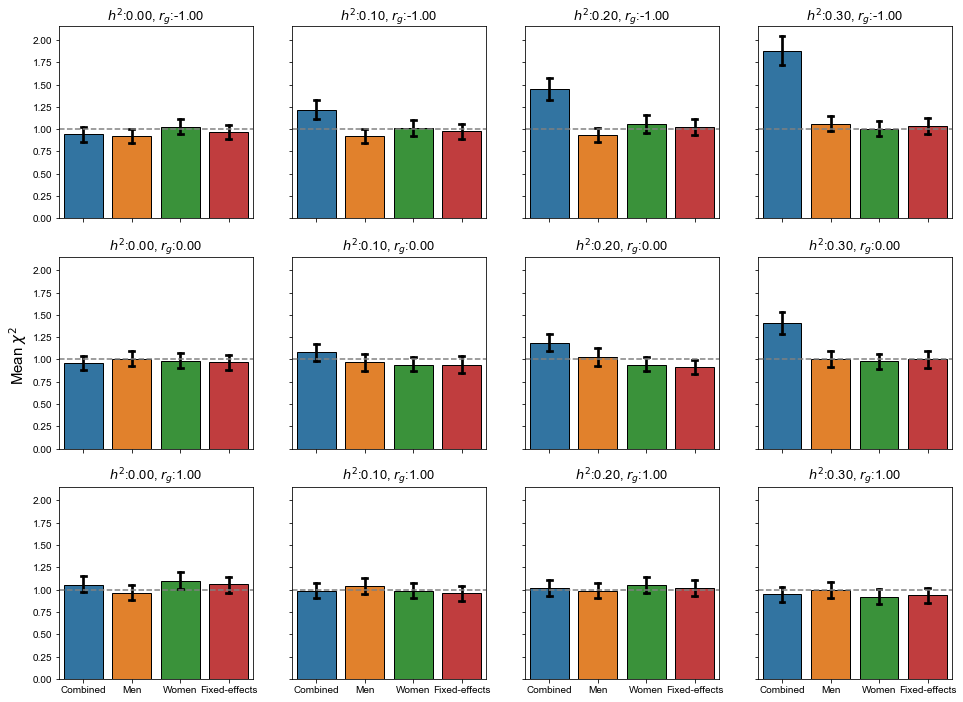

In [36]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        i_b0 = 0
        beta_1 = (bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err_1 = (ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta0_1 = (bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err0_1 = (ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta1_1 = (bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err1_1 = (ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

        wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
            wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
        err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))

        chi_1 = (beta_1/err_1) ** 2
        chi0_1 = (beta0_1/err0_1) ** 2
        chi1_1 = (beta1_1/err1_1) ** 2
        chi_combined_1 = (beta_combined_1/err_combined_1) ** 2
        data_plot = pd.melt(pd.DataFrame(np.vstack([chi_1, chi0_1, chi1_1, chi_combined_1]).T,
                                         columns=['Combined', 'Men', 'Women', 'Fixed-effects']))
       
        sns.barplot(x='variable',
                    y='value',
                    data=data_plot,
                    ax=ax[i_rg,i_h2],
                    capsize=0.1, 
                    errcolor = 'black',
                    edgecolor='black')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        #ax[i_rg,i_h2].legend(frameon=False, fontsize=12)
        ax[i_rg,i_h2].axhline(1, color='grey', ls='--')
        
fig.text(0.08, 0.5, r'Mean $\chi^2$', rotation='vertical', fontsize=15, va='center')

plt.show()            


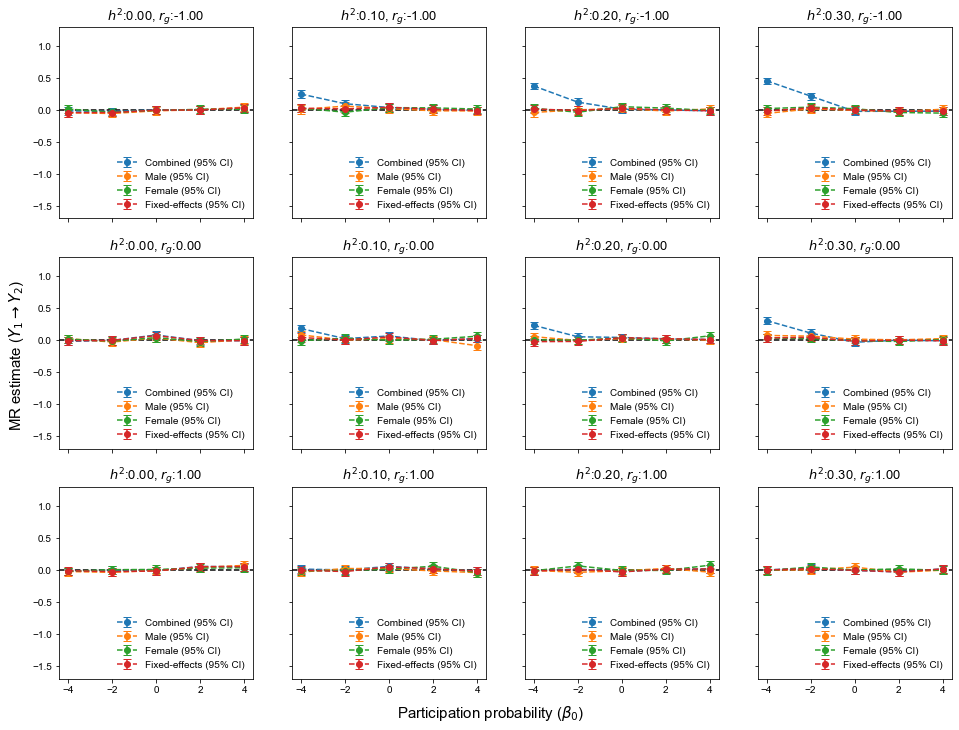

In [37]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        betas_1 = []
        errs_1 = []
        betas0_1 = []
        errs0_1 = []
        betas1_1 = []
        errs1_1 = []
        betas_combined_1 = []
        errs_combined_1 = []
        
        betas_2 = []
        errs_2 = []
        betas0_2 = []
        errs0_2 = []
        betas1_2 = []
        errs1_2 = []
        betas_combined_2 = []
        errs_combined_2 = []
        for i_b0, b0 in enumerate(b0s):
            betas_1.append(bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_1.append(ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_1.append(bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_1.append(ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_1.append(bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_1.append(ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
            err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))
            betas_combined_1.append(beta_combined_1)
            errs_combined_1.append(err_combined_1)
            
            betas_2.append(bs_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_2.append(ses_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_2.append(bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_2.append(ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_2.append(bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_2.append(ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_2 = ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_2 = ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_2 = (wt0_2 * bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_2 * bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_2+wt1_2)
            err_combined_2 = np.sqrt(1 / (wt0_2+wt1_2))
            betas_combined_2.append(beta_combined_2)
            errs_combined_2.append(err_combined_2)
        
        betas_1 = np.array(betas_1)
        errs_1 = np.array(errs_1)
        betas0_1 = np.array(betas0_1)
        errs0_1 = np.array(errs0_1)
        betas1_1 = np.array(betas1_1)
        errs1_1 = np.array(errs1_1)
        betas_combined_1 = np.array(betas_combined_1)
        errs_combined_1 = np.array(errs_combined_1)
        
        betas_2 = np.array(betas_2)
        errs_2 = np.array(errs_2)
        betas0_2 = np.array(betas0_2)
        errs0_2 = np.array(errs0_2)
        betas1_2 = np.array(betas1_2)
        errs1_2 = np.array(errs1_2)
        betas_combined_2 = np.array(betas_combined_2)
        errs_combined_2 = np.array(errs_combined_2)
        
        theta = (betas_1 * betas_2 * errs_2 ** (-2)).sum(axis=1) / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)
        theta0 = (betas0_1 * betas0_2 * errs0_2 ** (-2)).sum(axis=1) / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1)
        theta1 = (betas1_1 * betas1_2 * errs1_2 ** (-2)).sum(axis=1) / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1)
        theta_combined = (betas_combined_1 * betas_combined_2 * errs_combined_2 ** (-2)).sum(axis=1) / \
            (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1)
        
        tse = np.sqrt(1 / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)) # 7 x 1
        tse0 = np.sqrt(1 / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1))
        tse1 = np.sqrt(1 / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1))
        tse_combined = np.sqrt(1 / (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1))
        
        data_plot = pd.melt(pd.DataFrame(tse))
        
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta.ravel(), 
                                yerr=tse.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Combined (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta0.ravel(), 
                                yerr=tse0.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Male (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta1.ravel(), 
                                yerr=tse1.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Female (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta_combined.ravel(), 
                                yerr=tse_combined.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Fixed-effects (95% CI)')
        
        ax[i_rg,i_h2].axhline(0, color='black', ls='--')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        ax[i_rg,i_h2].set_ylim([-1.7,1.3])
        ax[i_rg,i_h2].legend(frameon=False, loc=4)
        
fig.text(0.08, 0.5, r'MR estimate ($Y_1 \rightarrow Y_2$)', rotation='vertical', fontsize=15, va='center')
fig.text(0.5, 0.08, r'Participation probability ($\beta_0$)', fontsize=15, ha='center')

plt.show()        
            


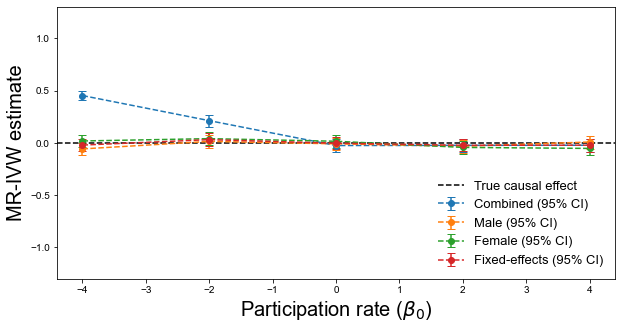

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

i_rg, i_h2 = 0, 3

betas_1 = []
errs_1 = []
betas0_1 = []
errs0_1 = []
betas1_1 = []
errs1_1 = []
betas_combined_1 = []
errs_combined_1 = []

betas_2 = []
errs_2 = []
betas0_2 = []
errs0_2 = []
betas1_2 = []
errs1_2 = []
betas_combined_2 = []
errs_combined_2 = []
for i_b0, b0 in enumerate(b0s):
    betas_1.append(bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs_1.append(ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    betas0_1.append(bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs0_1.append(ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    betas1_1.append(bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs1_1.append(ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

    wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
    wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
    beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
        wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
    err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))
    betas_combined_1.append(beta_combined_1)
    errs_combined_1.append(err_combined_1)

    betas_2.append(bs_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs_2.append(ses_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    betas0_2.append(bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs0_2.append(ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    betas1_2.append(bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
    errs1_2.append(ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

    wt0_2 = ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
    wt1_2 = ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
    beta_combined_2 = (wt0_2 * bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
        wt1_2 * bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_2+wt1_2)
    err_combined_2 = np.sqrt(1 / (wt0_2+wt1_2))
    betas_combined_2.append(beta_combined_2)
    errs_combined_2.append(err_combined_2)

betas_1 = np.array(betas_1)
errs_1 = np.array(errs_1)
betas0_1 = np.array(betas0_1)
errs0_1 = np.array(errs0_1)
betas1_1 = np.array(betas1_1)
errs1_1 = np.array(errs1_1)
betas_combined_1 = np.array(betas_combined_1)
errs_combined_1 = np.array(errs_combined_1)

betas_2 = np.array(betas_2)
errs_2 = np.array(errs_2)
betas0_2 = np.array(betas0_2)
errs0_2 = np.array(errs0_2)
betas1_2 = np.array(betas1_2)
errs1_2 = np.array(errs1_2)
betas_combined_2 = np.array(betas_combined_2)
errs_combined_2 = np.array(errs_combined_2)

theta = (betas_1 * betas_2 * errs_2 ** (-2)).sum(axis=1) / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)
theta0 = (betas0_1 * betas0_2 * errs0_2 ** (-2)).sum(axis=1) / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1)
theta1 = (betas1_1 * betas1_2 * errs1_2 ** (-2)).sum(axis=1) / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1)
theta_combined = (betas_combined_1 * betas_combined_2 * errs_combined_2 ** (-2)).sum(axis=1) / \
    (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1)

tse = np.sqrt(1 / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)) # 7 x 1
tse0 = np.sqrt(1 / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1))
tse1 = np.sqrt(1 / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1))
tse_combined = np.sqrt(1 / (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1))

data_plot = pd.melt(pd.DataFrame(tse))

ax.errorbar(x=b0s, 
                        y=theta.ravel(), 
                        yerr=tse.ravel()*1.96, 
                        marker='o', 
                        capsize=4,
                        linestyle='--', 
                        label='Combined (95% CI)')
ax.errorbar(x=b0s, 
                        y=theta0.ravel(), 
                        yerr=tse0.ravel()*1.96, 
                        marker='o', 
                        capsize=4,
                        linestyle='--', 
                        label='Male (95% CI)')
ax.errorbar(x=b0s, 
                        y=theta1.ravel(), 
                        yerr=tse1.ravel()*1.96, 
                        marker='o', 
                        capsize=4,
                        linestyle='--', 
                        label='Female (95% CI)')
ax.errorbar(x=b0s, 
                        y=theta_combined.ravel(), 
                        yerr=tse_combined.ravel()*1.96, 
                        marker='o', 
                        capsize=4,
                        linestyle='--', 
                        label='Fixed-effects (95% CI)')

ax.axhline(0, color='black', ls='--', label='True causal effect')

lab = labels[i_rg + nrg*i_h2] 
ax.set_xlabel(r'Participation rate ($\beta_0$)', fontsize=20)
ax.set_ylabel('MR-IVW estimate', fontsize=20)
ax.set_ylim([-1.3,1.3])
ax.legend(frameon=False, loc=4, fontsize=13)

plt.show()

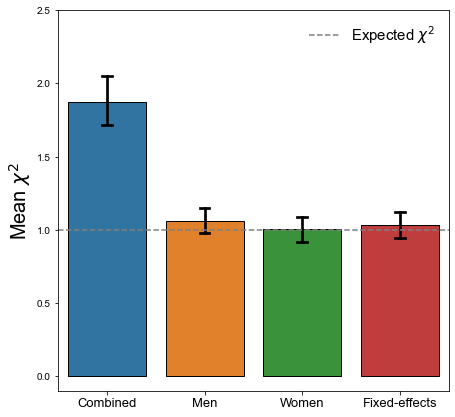

In [56]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(figsize=(7,7))
i_rg, i_h2 = 0, 3


i_b0 = 0
beta_1 = (bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
err_1 = (ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
beta0_1 = (bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
err0_1 = (ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
beta1_1 = (bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
err1_1 = (ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
    wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))

chi_1 = (beta_1/err_1) ** 2
chi0_1 = (beta0_1/err0_1) ** 2
chi1_1 = (beta1_1/err1_1) ** 2
chi_combined_1 = (beta_combined_1/err_combined_1) ** 2
data_plot = pd.melt(pd.DataFrame(np.vstack([chi_1, chi0_1, chi1_1, chi_combined_1]).T,
                                 columns=['Combined', 'Men', 'Women', 'Fixed-effects']))

sns.barplot(x='variable',
            y='value',
            data=data_plot,
            ax=ax,
            capsize=0.1, 
            errcolor = 'black',
            edgecolor='black')

lab = labels[i_rg + nrg*i_h2] 
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_ylabel(r'Mean $\chi^2$', fontsize=20)
ax.set_ylim([-0.1,2.5])
ax.axhline(1, color='grey', ls='--', label=r'Expected $\chi^2$')
ax.legend(frameon=False, fontsize=15)


plt.show()            


# trait prevalence 0.5 -> 0.1

In [11]:
n_snps = 1000
n_samp_target = 50000
freq_snps = np.random.uniform(low=0.1, high=0.9, size=n_snps)

nh2 = 4
nrg = 3

h2s = np.linspace(0, 0.3, nh2)
rgs = np.linspace(-1, 1, nrg)
b0s = np.linspace(-4, 4, 5)
labels = []

bs_1 = []
ses_1 = []
bs0_1 = []
ses0_1 = []
bs1_1 = []
ses1_1 = []

bs_2 = []
ses_2 = []
bs0_2 = []
ses0_2 = []
bs1_2 = []
ses1_2 = []

for b0 in b0s:
    p = 1/(1+np.exp(-b0))
    n_samp = int(n_samp_target/p)
    
    # simulate genotype
    gt = np.random.binomial(2, freq_snps, size=(n_samp, n_snps))
    
    # normalize genotype
    gt_norm = (gt - gt.mean(axis=0)) / gt.std(axis=0)
    
    # simulate selection
    for h2 in h2s:
        for rg in rgs:
            betas = np.random.multivariate_normal(np.zeros(2), [[h2, rg * h2], [rg * h2, h2]], size=n_snps) / np.sqrt(n_snps)
            noise = np.random.multivariate_normal(np.zeros(2), np.eye(2) * (1-h2), size=gt_norm.shape[0])
            
            sex = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            y1 = np.random.binomial(1, p=0.1, size=gt_norm.shape[0])
            y2 = np.random.binomial(1, p=0.1, size=gt_norm.shape[0])
            
            
            c_liab = (gt_norm @ betas) + noise + b0
            c1_liab = c_liab + 0.5 * ((2*sex-1) * y1)[:,None]
            c2_liab = c_liab + 0.5 * ((2*sex-1) * y2)[:,None]
            
            c1d = np.random.binomial(1, p=1/(1+np.exp(-c1_liab)))
            c2d = np.random.binomial(1, p=1/(1+np.exp(-c2_liab)))
            
            c1 = c1d[:,0] * (1-sex) + c1d[:,1] * sex
            c2 = c2d[:,0] * (1-sex) + c2d[:,1] * sex 
             
            # select samples and run regression
            gt_norm_c1 = gt_norm[c1.astype(bool),:]
            gt_norm_c2 = gt_norm[c2.astype(bool),:]
            sex_c1 = sex[c1.astype(bool)]
            sex_c2 = sex[c2.astype(bool)]
            y1_c = y1[c1.astype(bool)]
            y2_c = y2[c2.astype(bool)]
            
            beta_1 = np.zeros(n_snps)
            se_1 = np.zeros(n_snps)
            beta0_1 = np.zeros(n_snps)
            se0_1 = np.zeros(n_snps)
            beta1_1 = np.zeros(n_snps)
            se1_1 = np.zeros(n_snps)
            
            beta_2 = np.zeros(n_snps)
            se_2 = np.zeros(n_snps)
            beta0_2 = np.zeros(n_snps)
            se0_2 = np.zeros(n_snps)
            beta1_2 = np.zeros(n_snps)
            se1_2 = np.zeros(n_snps)
            
            for i_snp in range(n_snps):
                mod_1 = sm.GLM(endog=y1_c, exog=sm.add_constant(gt_norm_c1[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_1[i_snp] = mod_1.params[1]
                se_1[i_snp] = mod_1.bse[1]
                
                mod0_1 = sm.GLM(endog=y1_c[sex_c1==0], exog=sm.add_constant(gt_norm_c1[sex_c1==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_1[i_snp] = mod0_1.params[1]
                se0_1[i_snp] = mod0_1.bse[1]
                
                mod1_1 = sm.GLM(endog=y1_c[sex_c1==1], exog=sm.add_constant(gt_norm_c1[sex_c1==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_1[i_snp] = mod1_1.params[1]
                se1_1[i_snp] = mod1_1.bse[1]
                # ---------------------------------------------------------------------------------------
                mod_2 = sm.GLM(endog=y2_c, exog=sm.add_constant(gt_norm_c2[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_2[i_snp] = mod_2.params[1]
                se_2[i_snp] = mod_2.bse[1]
                
                mod0_2 = sm.GLM(endog=y2_c[sex_c2==0], exog=sm.add_constant(gt_norm_c2[sex_c2==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_2[i_snp] = mod0_2.params[1]
                se0_2[i_snp] = mod0_2.bse[1]
                
                mod1_2 = sm.GLM(endog=y2_c[sex_c2==1], exog=sm.add_constant(gt_norm_c2[sex_c2==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_2[i_snp] = mod1_2.params[1]
                se1_2[i_snp] = mod1_2.bse[1]
                
            bs_1.append(beta_1)
            ses_1.append(se_1)
            bs0_1.append(beta0_1)
            ses0_1.append(se0_1)
            bs1_1.append(beta1_1)
            ses1_1.append(se1_1)
            
            bs_2.append(beta_2)
            ses_2.append(se_2)
            bs0_2.append(beta0_2)
            ses0_2.append(se0_2)
            bs1_2.append(beta1_2)
            ses1_2.append(se1_2)
            
            labels.append([b0, h2, rg])

import pickle
save_data = [bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2]
file_to_store = open("result/participation_0.1.pickle", "wb")
pickle.dump(save_data, file_to_store)
file_to_store.close()

In [23]:
with open('result/participation_0.1.pickle', 'rb') as f:
    data_load = pickle.load(f)
    bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2 = data_load

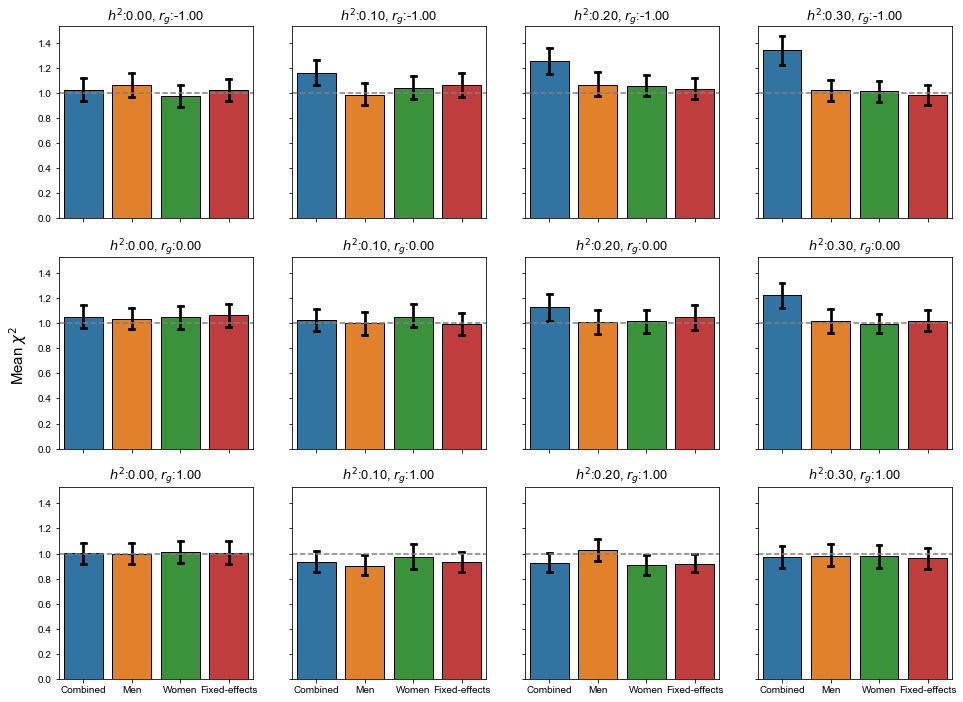

In [24]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        i_b0 = 0
        beta_1 = (bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err_1 = (ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta0_1 = (bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err0_1 = (ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta1_1 = (bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err1_1 = (ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

        wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
            wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
        err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))

        chi_1 = (beta_1/err_1) ** 2
        chi0_1 = (beta0_1/err0_1) ** 2
        chi1_1 = (beta1_1/err1_1) ** 2
        chi_combined_1 = (beta_combined_1/err_combined_1) ** 2
        data_plot = pd.melt(pd.DataFrame(np.vstack([chi_1, chi0_1, chi1_1, chi_combined_1]).T,
                                         columns=['Combined', 'Men', 'Women', 'Fixed-effects']))
       
        sns.barplot(x='variable',
                    y='value',
                    data=data_plot,
                    ax=ax[i_rg,i_h2],
                    capsize=0.1, 
                    errcolor = 'black',
                    edgecolor='black')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        #ax[i_rg,i_h2].legend(frameon=False, fontsize=12)
        ax[i_rg,i_h2].axhline(1, color='grey', ls='--')
        
fig.text(0.08, 0.5, r'Mean $\chi^2$', rotation='vertical', fontsize=15, va='center')

plt.show()            


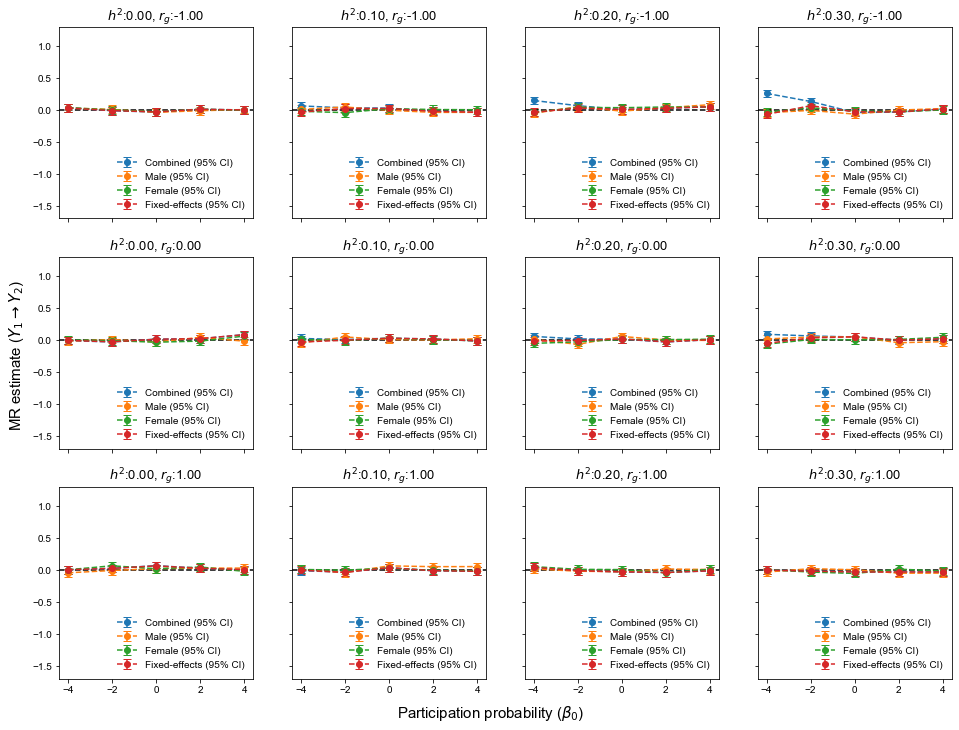

In [25]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        betas_1 = []
        errs_1 = []
        betas0_1 = []
        errs0_1 = []
        betas1_1 = []
        errs1_1 = []
        betas_combined_1 = []
        errs_combined_1 = []
        
        betas_2 = []
        errs_2 = []
        betas0_2 = []
        errs0_2 = []
        betas1_2 = []
        errs1_2 = []
        betas_combined_2 = []
        errs_combined_2 = []
        for i_b0, b0 in enumerate(b0s):
            betas_1.append(bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_1.append(ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_1.append(bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_1.append(ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_1.append(bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_1.append(ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
            err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))
            betas_combined_1.append(beta_combined_1)
            errs_combined_1.append(err_combined_1)
            
            betas_2.append(bs_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_2.append(ses_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_2.append(bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_2.append(ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_2.append(bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_2.append(ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_2 = ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_2 = ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_2 = (wt0_2 * bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_2 * bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_2+wt1_2)
            err_combined_2 = np.sqrt(1 / (wt0_2+wt1_2))
            betas_combined_2.append(beta_combined_2)
            errs_combined_2.append(err_combined_2)
        
        betas_1 = np.array(betas_1)
        errs_1 = np.array(errs_1)
        betas0_1 = np.array(betas0_1)
        errs0_1 = np.array(errs0_1)
        betas1_1 = np.array(betas1_1)
        errs1_1 = np.array(errs1_1)
        betas_combined_1 = np.array(betas_combined_1)
        errs_combined_1 = np.array(errs_combined_1)
        
        betas_2 = np.array(betas_2)
        errs_2 = np.array(errs_2)
        betas0_2 = np.array(betas0_2)
        errs0_2 = np.array(errs0_2)
        betas1_2 = np.array(betas1_2)
        errs1_2 = np.array(errs1_2)
        betas_combined_2 = np.array(betas_combined_2)
        errs_combined_2 = np.array(errs_combined_2)
        
        theta = (betas_1 * betas_2 * errs_2 ** (-2)).sum(axis=1) / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)
        theta0 = (betas0_1 * betas0_2 * errs0_2 ** (-2)).sum(axis=1) / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1)
        theta1 = (betas1_1 * betas1_2 * errs1_2 ** (-2)).sum(axis=1) / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1)
        theta_combined = (betas_combined_1 * betas_combined_2 * errs_combined_2 ** (-2)).sum(axis=1) / \
            (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1)
        
        tse = np.sqrt(1 / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)) # 7 x 1
        tse0 = np.sqrt(1 / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1))
        tse1 = np.sqrt(1 / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1))
        tse_combined = np.sqrt(1 / (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1))
        
        data_plot = pd.melt(pd.DataFrame(tse))
        
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta.ravel(), 
                                yerr=tse.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Combined (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta0.ravel(), 
                                yerr=tse0.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Male (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta1.ravel(), 
                                yerr=tse1.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Female (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta_combined.ravel(), 
                                yerr=tse_combined.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Fixed-effects (95% CI)')
        
        ax[i_rg,i_h2].axhline(0, color='black', ls='--')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        ax[i_rg,i_h2].set_ylim([-1.7,1.3])
        ax[i_rg,i_h2].legend(frameon=False, loc=4)
        
fig.text(0.08, 0.5, r'MR estimate ($Y_1 \rightarrow Y_2$)', rotation='vertical', fontsize=15, va='center')
fig.text(0.5, 0.08, r'Participation probability ($\beta_0$)', fontsize=15, ha='center')

plt.show()        
            


# sex differential prevalence

In [12]:
n_snps = 1000
n_samp_target = 50000
freq_snps = np.random.uniform(low=0.1, high=0.9, size=n_snps)

nh2 = 4
nrg = 3

h2s = np.linspace(0, 0.3, nh2)
rgs = np.linspace(-1, 1, nrg)
b0s = np.linspace(-4, 4, 5)
labels = []

bs_1 = []
ses_1 = []
bs0_1 = []
ses0_1 = []
bs1_1 = []
ses1_1 = []

bs_2 = []
ses_2 = []
bs0_2 = []
ses0_2 = []
bs1_2 = []
ses1_2 = []

for b0 in b0s:
    p = 1/(1+np.exp(-b0))
    n_samp = int(n_samp_target/p)
    
    # simulate genotype
    gt = np.random.binomial(2, freq_snps, size=(n_samp, n_snps))
    
    # normalize genotype
    gt_norm = (gt - gt.mean(axis=0)) / gt.std(axis=0)
    
    # simulate selection
    for h2 in h2s:
        for rg in rgs:
            betas = np.random.multivariate_normal(np.zeros(2), [[h2, rg * h2], [rg * h2, h2]], size=n_snps) / np.sqrt(n_snps)
            noise = np.random.multivariate_normal(np.zeros(2), np.eye(2) * (1-h2), size=gt_norm.shape[0])
            
            sex = np.random.binomial(1, p=0.5, size=gt_norm.shape[0])
            y1 = np.random.binomial(1, p=0.1 + 0.2*sex, size=gt_norm.shape[0])
            y2 = np.random.binomial(1, p=0.1 + 0.2*sex, size=gt_norm.shape[0])
            
            
            c_liab = (gt_norm @ betas) + noise + b0
            c1_liab = c_liab + 0.5 * ((2*sex-1) * y1)[:,None]
            c2_liab = c_liab + 0.5 * ((2*sex-1) * y2)[:,None]
            
            c1d = np.random.binomial(1, p=1/(1+np.exp(-c1_liab)))
            c2d = np.random.binomial(1, p=1/(1+np.exp(-c2_liab)))
            
            c1 = c1d[:,0] * (1-sex) + c1d[:,1] * sex
            c2 = c2d[:,0] * (1-sex) + c2d[:,1] * sex 
             
            # select samples and run regression
            gt_norm_c1 = gt_norm[c1.astype(bool),:]
            gt_norm_c2 = gt_norm[c2.astype(bool),:]
            sex_c1 = sex[c1.astype(bool)]
            sex_c2 = sex[c2.astype(bool)]
            y1_c = y1[c1.astype(bool)]
            y2_c = y2[c2.astype(bool)]
            
            beta_1 = np.zeros(n_snps)
            se_1 = np.zeros(n_snps)
            beta0_1 = np.zeros(n_snps)
            se0_1 = np.zeros(n_snps)
            beta1_1 = np.zeros(n_snps)
            se1_1 = np.zeros(n_snps)
            
            beta_2 = np.zeros(n_snps)
            se_2 = np.zeros(n_snps)
            beta0_2 = np.zeros(n_snps)
            se0_2 = np.zeros(n_snps)
            beta1_2 = np.zeros(n_snps)
            se1_2 = np.zeros(n_snps)
            
            for i_snp in range(n_snps):
                mod_1 = sm.GLM(endog=y1_c, exog=sm.add_constant(gt_norm_c1[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_1[i_snp] = mod_1.params[1]
                se_1[i_snp] = mod_1.bse[1]
                
                mod0_1 = sm.GLM(endog=y1_c[sex_c1==0], exog=sm.add_constant(gt_norm_c1[sex_c1==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_1[i_snp] = mod0_1.params[1]
                se0_1[i_snp] = mod0_1.bse[1]
                
                mod1_1 = sm.GLM(endog=y1_c[sex_c1==1], exog=sm.add_constant(gt_norm_c1[sex_c1==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_1[i_snp] = mod1_1.params[1]
                se1_1[i_snp] = mod1_1.bse[1]
                # ---------------------------------------------------------------------------------------
                mod_2 = sm.GLM(endog=y2_c, exog=sm.add_constant(gt_norm_c2[:,i_snp]), family=sm.families.Binomial()).fit()
                beta_2[i_snp] = mod_2.params[1]
                se_2[i_snp] = mod_2.bse[1]
                
                mod0_2 = sm.GLM(endog=y2_c[sex_c2==0], exog=sm.add_constant(gt_norm_c2[sex_c2==0,i_snp]), family=sm.families.Binomial()).fit()
                beta0_2[i_snp] = mod0_2.params[1]
                se0_2[i_snp] = mod0_2.bse[1]
                
                mod1_2 = sm.GLM(endog=y2_c[sex_c2==1], exog=sm.add_constant(gt_norm_c2[sex_c2==1,i_snp]), family=sm.families.Binomial()).fit()
                beta1_2[i_snp] = mod1_2.params[1]
                se1_2[i_snp] = mod1_2.bse[1]
                
            bs_1.append(beta_1)
            ses_1.append(se_1)
            bs0_1.append(beta0_1)
            ses0_1.append(se0_1)
            bs1_1.append(beta1_1)
            ses1_1.append(se1_1)
            
            bs_2.append(beta_2)
            ses_2.append(se_2)
            bs0_2.append(beta0_2)
            ses0_2.append(se0_2)
            bs1_2.append(beta1_2)
            ses1_2.append(se1_2)
            
            labels.append([b0, h2, rg])

import pickle
save_data = [bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2]
file_to_store = open("result/participation_sex_0.1_0.3.pickle", "wb")
pickle.dump(save_data, file_to_store)
file_to_store.close()

In [ ]:
with open('result/participation_sex_0.1_0.3.pickle', 'rb') as f:
    data_load = pickle.load(f)
    bs_1,ses_1,bs0_1,ses0_1,bs1_1,ses1_1,bs_2,ses_2,bs0_2,ses0_2,bs1_2,ses1_2 = data_load

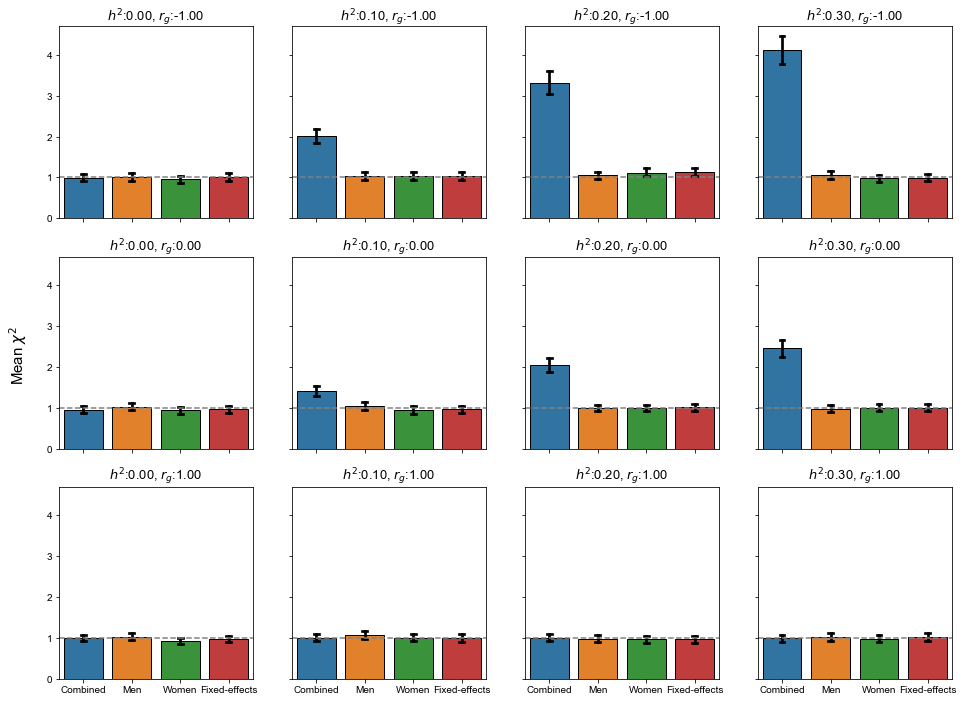

In [13]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        i_b0 = 0
        beta_1 = (bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err_1 = (ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta0_1 = (bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err0_1 = (ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        beta1_1 = (bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
        err1_1 = (ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])

        wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
        beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
            wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
        err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))

        chi_1 = (beta_1/err_1) ** 2
        chi0_1 = (beta0_1/err0_1) ** 2
        chi1_1 = (beta1_1/err1_1) ** 2
        chi_combined_1 = (beta_combined_1/err_combined_1) ** 2
        data_plot = pd.melt(pd.DataFrame(np.vstack([chi_1, chi0_1, chi1_1, chi_combined_1]).T,
                                         columns=['Combined', 'Men', 'Women', 'Fixed-effects']))
       
        sns.barplot(x='variable',
                    y='value',
                    data=data_plot,
                    ax=ax[i_rg,i_h2],
                    capsize=0.1, 
                    errcolor = 'black',
                    edgecolor='black')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        #ax[i_rg,i_h2].legend(frameon=False, fontsize=12)
        ax[i_rg,i_h2].axhline(1, color='grey', ls='--')
        
fig.text(0.08, 0.5, r'Mean $\chi^2$', rotation='vertical', fontsize=15, va='center')

plt.show()            


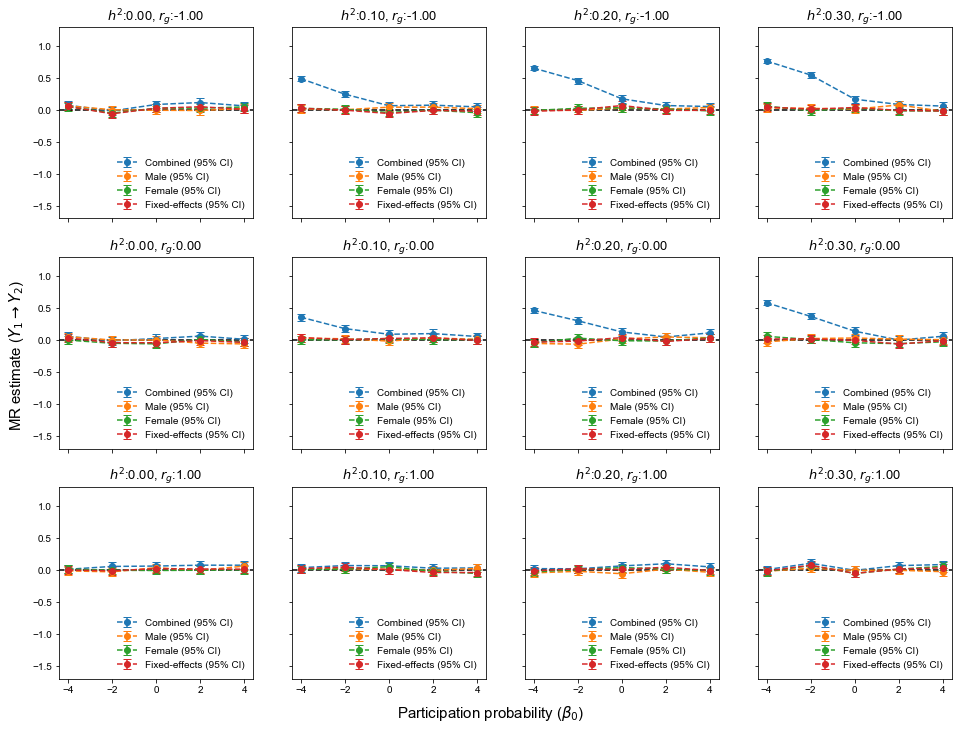

In [14]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001579/
# https://academic.oup.com/aje/article/181/4/290/122428

fig, ax = plt.subplots(nrg,nh2,figsize=(16,12), sharex=True, sharey=True)

for i_h2, h2 in enumerate(h2s):
    for i_rg, rg in enumerate(rgs):
        betas_1 = []
        errs_1 = []
        betas0_1 = []
        errs0_1 = []
        betas1_1 = []
        errs1_1 = []
        betas_combined_1 = []
        errs_combined_1 = []
        
        betas_2 = []
        errs_2 = []
        betas0_2 = []
        errs0_2 = []
        betas1_2 = []
        errs1_2 = []
        betas_combined_2 = []
        errs_combined_2 = []
        for i_b0, b0 in enumerate(b0s):
            betas_1.append(bs_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_1.append(ses_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_1.append(bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_1.append(ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_1.append(bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_1.append(ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_1 = ses0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_1 = ses1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_1 = (wt0_1 * bs0_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_1 * bs1_1[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_1+wt1_1)
            err_combined_1 = np.sqrt(1 / (wt0_1+wt1_1))
            betas_combined_1.append(beta_combined_1)
            errs_combined_1.append(err_combined_1)
            
            betas_2.append(bs_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs_2.append(ses_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas0_2.append(bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs0_2.append(ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            betas1_2.append(bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            errs1_2.append(ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0])
            
            wt0_2 = ses0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            wt1_2 = ses1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] ** (-2)
            beta_combined_2 = (wt0_2 * bs0_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0] + \
                wt1_2 * bs1_2[i_rg + nrg*i_h2 + nrg*nh2*i_b0]) / (wt0_2+wt1_2)
            err_combined_2 = np.sqrt(1 / (wt0_2+wt1_2))
            betas_combined_2.append(beta_combined_2)
            errs_combined_2.append(err_combined_2)
        
        betas_1 = np.array(betas_1)
        errs_1 = np.array(errs_1)
        betas0_1 = np.array(betas0_1)
        errs0_1 = np.array(errs0_1)
        betas1_1 = np.array(betas1_1)
        errs1_1 = np.array(errs1_1)
        betas_combined_1 = np.array(betas_combined_1)
        errs_combined_1 = np.array(errs_combined_1)
        
        betas_2 = np.array(betas_2)
        errs_2 = np.array(errs_2)
        betas0_2 = np.array(betas0_2)
        errs0_2 = np.array(errs0_2)
        betas1_2 = np.array(betas1_2)
        errs1_2 = np.array(errs1_2)
        betas_combined_2 = np.array(betas_combined_2)
        errs_combined_2 = np.array(errs_combined_2)
        
        theta = (betas_1 * betas_2 * errs_2 ** (-2)).sum(axis=1) / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)
        theta0 = (betas0_1 * betas0_2 * errs0_2 ** (-2)).sum(axis=1) / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1)
        theta1 = (betas1_1 * betas1_2 * errs1_2 ** (-2)).sum(axis=1) / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1)
        theta_combined = (betas_combined_1 * betas_combined_2 * errs_combined_2 ** (-2)).sum(axis=1) / \
            (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1)
        
        tse = np.sqrt(1 / (betas_1 ** 2 * errs_2 ** (-2)).sum(axis=1)) # 7 x 1
        tse0 = np.sqrt(1 / (betas0_1 ** 2 * errs0_2 ** (-2)).sum(axis=1))
        tse1 = np.sqrt(1 / (betas1_1 ** 2 * errs1_2 ** (-2)).sum(axis=1))
        tse_combined = np.sqrt(1 / (betas_combined_1 ** 2 * errs_combined_2 ** (-2)).sum(axis=1))
        
        data_plot = pd.melt(pd.DataFrame(tse))
        
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta.ravel(), 
                                yerr=tse.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Combined (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta0.ravel(), 
                                yerr=tse0.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Male (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta1.ravel(), 
                                yerr=tse1.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Female (95% CI)')
        ax[i_rg, i_h2].errorbar(x=b0s, 
                                y=theta_combined.ravel(), 
                                yerr=tse_combined.ravel()*1.96, 
                                marker='o', 
                                capsize=4,
                                linestyle='--', 
                                label='Fixed-effects (95% CI)')
        
        ax[i_rg,i_h2].axhline(0, color='black', ls='--')
        
        lab = labels[i_rg + nrg*i_h2] 
        ax[i_rg,i_h2].set_xlabel('')
        ax[i_rg,i_h2].set_ylabel('')
        ax[i_rg,i_h2].set_title(r'$h^2$:%.2f, $r_g$:%.2f' % (lab[1], lab[2]),fontsize=13)
        ax[i_rg,i_h2].set_ylim([-1.7,1.3])
        ax[i_rg,i_h2].legend(frameon=False, loc=4)
        
fig.text(0.08, 0.5, r'MR estimate ($Y_1 \rightarrow Y_2$)', rotation='vertical', fontsize=15, va='center')
fig.text(0.5, 0.08, r'Participation probability ($\beta_0$)', fontsize=15, ha='center')

plt.show()        
            
